## Introduction

The objective of this repository is to to extend the classic DL time series modeling into a probabilistic framework and overcome the limitations of classic deep learning time series architecture which give deterministic result without quantifying the uncertainty.

In this notebook, we have implemented the DeepAR paper 

**DeepAR: Probabilistic forecasting with autoregressive recurrent networks,**

David Salinas, Valentin Flunkert, Jan Gasthaus, Tim Januschowski,

International Journal of Forecasting,
Volume 36, Issue 3,
2020,
Pages 1181-1191,
ISSN 0169-2070,

https://doi.org/10.1016/j.ijforecast.2019.07.001

## DeepAR

**DeepAR** is a methodology for producing accurate probabilistic forecasts, based on
training an auto-regressive recurrent network model on a large number of related
time series. The method
builds upon previous work on deep learning for time series data, and tailors a similar
LSTM-based recurrent neural network architecture to the probabilistic forecasting problem.

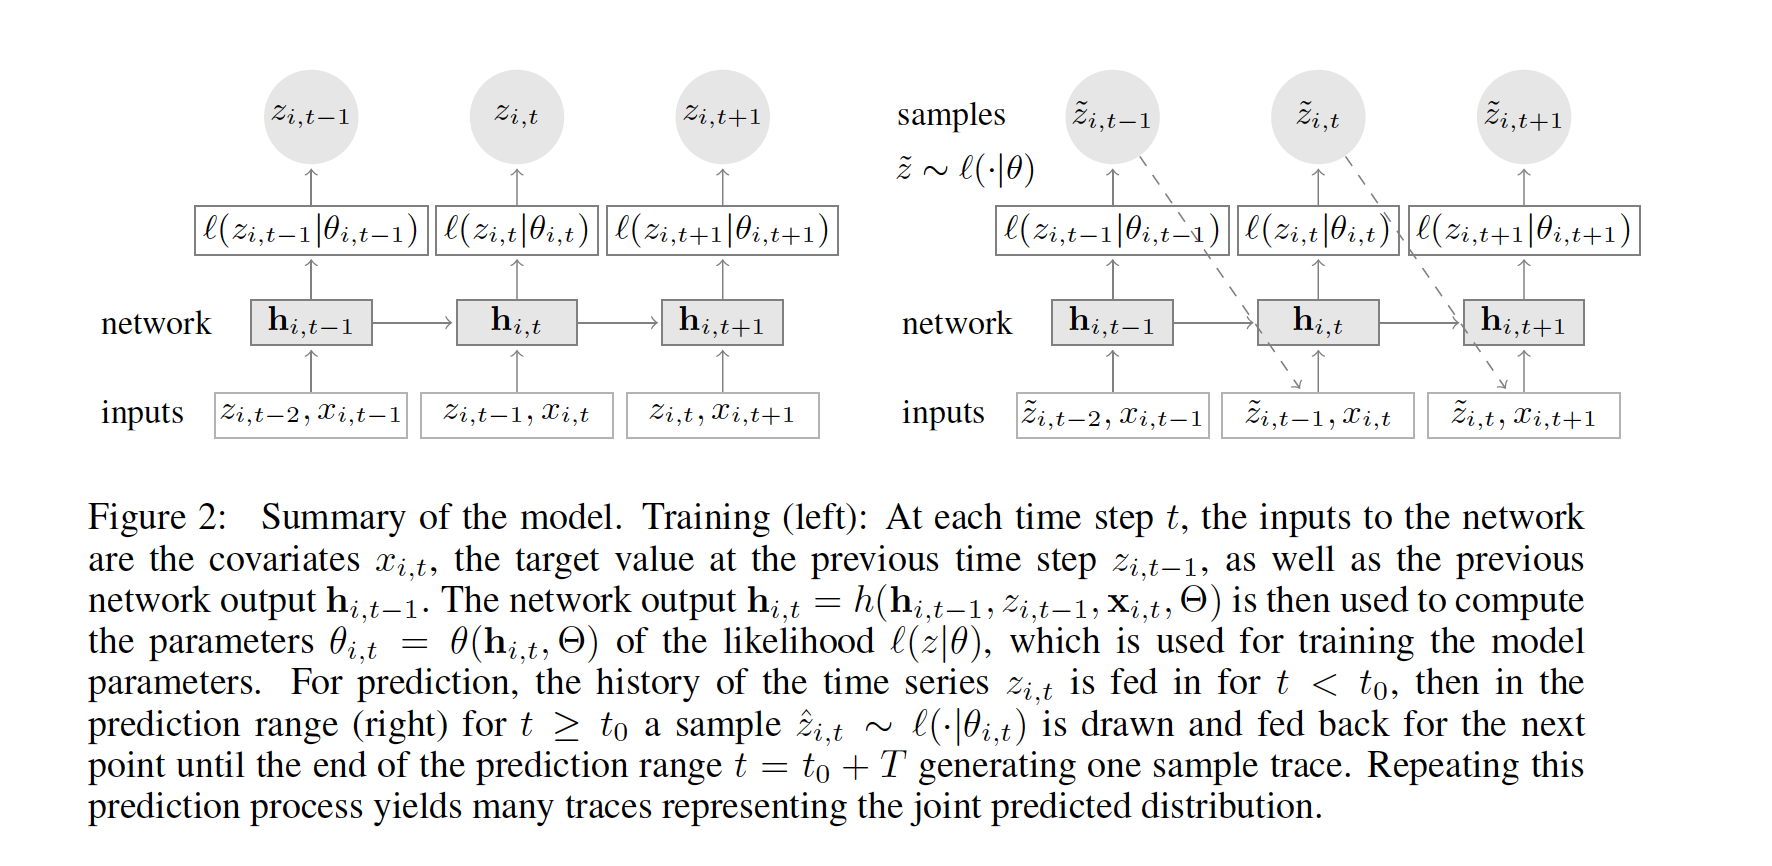

In [1]:
from IPython.display import Image
Image("/Users/srtpan/Downloads/1.png")

Image from the paper DeepAR: Probabilistic forecasting with autoregressive recurrent networks , Salinas et al., 2020

In the above diagram, $x_{i,t}$ refers to the covariate at timestep $t$, $z_{i,t-1}$ refers to the target value at timestep $t-1$, and $h_{i,t-1}$ refers to the last output. 

We wish to model the following probability distribution:

$$ P (z_{i;t_0:T} | z_{i;1:t_0-1}, x_{i,1:T}) $$

(equation taken from Salinas et al.) Instead of referring to "past" and "future", the authors have referred to time ranges as "conditioning range" and "prediction range"

**Conditioning range:** Time range [1, $t_0$-1] 

**Prediction range:** Time range [$t_0$, T] 


When we are training, we have access to the "past" (conditioning) and "future" (prediction) targets, but not while we are predicting -- then we will have only conditioning targets.

The authors have implemented DeepAR as a modification of an architecture called an **"Autoregressive Recurrent Network architecture"**

An autoregressive model is when a value from data with a temporal dimension are regressed on previous values up to a certain point specified by the user. An RNN works the same way but the obvious difference in comparison is that the RNN looks at all the data i.e. it does not require a specific time period to be specified by the user.

The model distribution is given by multiplying "likelihood factors" (this is an assumption made by the authors):

$\begin{equation*}
 Q (z_{i;t0:T} | z_{i,1:t0-1}, x_{i,1:T})= \prod_{t=t_0}^{T} Q (z_{i;t} | z_{i,1:t-1}, x_{i,1:T}) = \prod_{t=t_0}^{T} l (z_{i;t} | \theta(h_{i,t}, \phi))
\end{equation*}$

(equation taken from Salinas et al.) 

The parameters of the above are given by:

$$h_{i,t}=h(h_{i,t-1,z_{i,t-1}}, x_{i,t}, \phi)$$

(equation taken from Salinas et al.)


1. Gaussian likelihood is used for real-valued data. The paper uses a modified version of standard deviation using softplus activation function -- things go wrong when we enter the negative numbers.


2. The Negative-binomial likelihood is used for positive count data. In the below equation, $\mu$ is the mean and $\alpha$ is a shape parameter:

$$\begin{equation*}
    l_{NB}(z|\mu,\alpha) = \frac{\gamma(z+ \frac{1}{\alpha})}{\gamma(z+1)\gamma\frac{1}{\alpha}} (\frac{1}{1+\alpha \mu})^\frac{1}{\alpha} (\frac{\alpha \mu}{1+\alpha \mu})^z
\end{equation*}$$

(equation taken from Salinas et al.)

## Likelihood model

The likelihood $l(z|\theta)$ determines the “noise model”, and is chosen to match the statistical
properties of the data. 

The likelihood models chosen for this paper are: 

1. Gaussian likelihood for real-valued data

2. Negative-binomial likelihood for positive count data.

The parametrization of the models is discussed below along with the code!

## Training the model

For a data set of time series $z_{i,1:T gi=1,,,,N}$ and associated covariates $x_{i,1:T}$ , obtained by choosing
a time range such that $z_{i,t}$ in the prediction range is known, the parameters   of the model, are learned by maximizing the log likelihood:

$$\begin{equation*}
 L = \sum_{i=1}^{N} \sum_{t=t_{0}}^{T} log l (z_{i,t} | \theta(h_{i,t}))
\end{equation*}$$

For each time series in the dataset, multiple training instances are generated by selecting windows with
different starting points from the original time series. In practice, the total length T as well
as the relative length of the conditioning and prediction ranges are kept fixed for all training examples.

## Exploring the SP500 datasets

We have three datasets available to us. 

1. **sp500_companies** enlists all the companies represented on the SP500 metric with their symbol, long and short names, industry, current stock price, market cap, ebidta, revenue growth, location, eomployee count and weight of each company in the index. The sum of weights of all companies is 1, as expected. 

2. **sp500_stocks** contains the historical data of sp500 from 11/05/2012 to 11/04/2022

3. **sp500_stocks** mentions the adjusting closing, closing, high, low opening and volume of shares traded for each company from 11/05/2012 to 11/04/2022

In [2]:
#importing the libraries 

import pandas as pd
from random import seed

import numpy as np
import torch
from torch import optim
from torch.autograd import Variable
from torch.utils.data import DataLoader

import datetime
from random import randint

import pandas as pd
import numpy as np
from dateutil.relativedelta import relativedelta
import torch.nn as nn
import torch.nn.functional as F
from math import pi, sin, cos

import torch
import torch.utils.data as data

from torch.distributions import Gamma, Poisson
import matplotlib.pyplot as plt

In [3]:
#importing all the data

sp500_companies=pd.read_csv("/Users/srtpan/Desktop/Fall 22/DL/Final Project/Dataset/sp500_companies.csv")
sp500_index=pd.read_csv("/Users/srtpan/Desktop/Fall 22/DL/Final Project/Dataset/sp500_index.csv")
sp500_stocks=pd.read_csv("/Users/srtpan/Desktop/Fall 22/DL/Final Project/Dataset/sp500_stocks.csv")

In [4]:
#displaying first 5 rows of the sp500_companies data 

sp500_companies.head()

,Exchange,Symbol,Shortname,Longname,Sector,Industry,Currentprice,Marketcap,Ebitda,Revenuegrowth,City,State,Country,Fulltimeemployees,Longbusinesssummary,Weight
0,NMS,AAPL,Apple Inc.,Apple Inc.,Technology,Consumer Electronics,138.38,2201362890752,1.305410e+11,0.081,Cupertino,CA,United States,164000.0,"Apple Inc. designs, manufactures, and markets ...",0.065720
1,NMS,MSFT,Microsoft Corporation,Microsoft Corporation,Technology,Software—Infrastructure,221.39,1662191665152,9.798300e+10,0.124,Redmond,WA,United States,221000.0,"Microsoft Corporation develops, licenses, and ...",0.049623
2,NMS,GOOG,Alphabet Inc.,Alphabet Inc.,Communication Services,Internet Content & Information,86.70,1121334460416,9.373300e+10,0.061,Mountain View,CA,United States,186779.0,Alphabet Inc. provides various products and pl...,0.033477
3,NMS,GOOGL,Alphabet Inc.,Alphabet Inc.,Communication Services,Internet Content & Information,86.58,1121332232192,9.373300e+10,0.061,Mountain View,CA,United States,186779.0,Alphabet Inc. provides various products and pl...,0.033477
4,NMS,AMZN,"Amazon.com, Inc.","Amazon.com, Inc.",Consumer Cyclical,Internet Retail,90.98,928150716416,5.154900e+10,0.147,Seattle,WA,United States,1544000.0,"Amazon.com, Inc. engages in the retail sale of...",0.027709


In [5]:
#asserting that weight of all companies add to 1 

sp500_companies['Weight'].sum()

0.9999999999999751

In [6]:
#looking at number of sectors in the sp500_companies dataset

sp500_companies['Sector'].value_counts()

Industrials               72
Technology                71
Financial Services        68
Healthcare                64
Consumer Cyclical         57
Consumer Defensive        36
Real Estate               32
Utilities                 29
Energy                    23
Communication Services    22
Basic Materials           21
Name: Sector, dtype: int64

In [7]:
#displaying first 5 rows of sp500_index dataset

sp500_index.tail(450)

,Date,S&P500
2069,2021-01-26,3849.62
2070,2021-01-27,3750.77
2071,2021-01-28,3787.38
2072,2021-01-29,3714.24
2073,2021-02-01,3773.86
...,...,...
2514,2022-10-31,3871.98
2515,2022-11-01,3856.10
2516,2022-11-02,3759.69
2517,2022-11-03,3719.89


In [8]:
#displaying first 5 rows of sp500_stocks dataset

sp500_stocks[sp500_stocks["Symbol"]=="AAPL"].head()

#batch_first=False for LSTM in Pytorch

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
145530,2010-01-04,AAPL,6.572423,7.643214,7.660714,7.585000,7.622500,493729600.0
145531,2010-01-05,AAPL,6.583786,7.656429,7.699643,7.616071,7.664286,601904800.0
145532,2010-01-06,AAPL,6.479064,7.534643,7.686786,7.526786,7.656429,552160000.0
145533,2010-01-07,AAPL,6.467087,7.520714,7.571429,7.466071,7.562500,477131200.0
145534,2010-01-08,AAPL,6.510081,7.570714,7.571429,7.466429,7.510714,447610800.0


## Preprocessing the data according to paper

In [9]:
def count_positive(v):
    
    """
    A function to get the count of all positive digits in an input v 
    to apply negative binomial likelihood model
    
    Input: V (array of input)
    Output: Count of positive values (integer)
    
    """
    count_positive = 0
    for i in range(len(v)):
        if v[i] > 0:
            count += 1
    return count_positive


def date_preprocessing(s, v, datetime_module: datetime.datetime, i: int, t: int, format_):
    """
    A function to get date and time in standard format for further processing. 
    Datetime module present in Python is used for various modifications 
    
    Input: 
    
    s: time series, the index is date with/without time and values associated to date and time 
    v: mean of data within a specified time period
    i: integer that varies from 1 to N 
    t: integer that varies from t_0 to T 
    format_: parameter used for datetime module in python, can be 'm','h'
    
    Output: 
    x: normalized time series (s) between i and t-1
    z: time series (s) from i to t
    
    """
    x = []
    _, T = s.shape
    x.append(s[i, t - 1] / v[i])
    x.append(t / T)
    d = datetime_module
    if format_ == 'm':
        d += relativedelta(months=t)
        x.append(sin(2 * pi * ((d.month - 1) / 11)))
        x.append(cos(2 * pi * ((d.month - 1) / 11)))
    elif format_ == 'h':
        d += relativedelta(hours=t)
        x.append(sin(2 * pi * (d.hour / 23)))
        x.append(cos(2 * pi * (d.hour / 23)))
        weekday = d.weekday()
        x.append(sin(2 * pi * (weekday / 6)))
        x.append(cos(2 * pi * (weekday / 6)))
    else:
        print('{} format not supported'.format(format_))
    z = s[i, t]
    return x, z


def moving_window(s, v, datetime_module:datetime.datetime, i: int, t_window: int, window_len: int, format_):
    """
    A function to return a sample of data within a window size, provided as a parameter to the function
    
    Input: 
    
    s: time series, the index is date with/without time with values associated to date and time 
    v: mean of data within a specified time period
    i: integer that varies from 1 to N 
    t: integer that varies from t_0 to T 
    datetime_module: importing datetime module in python
    format_: parameter used for datetime module in python, can be 'm','h'
    
    Output: 
    X: array containing processed time series data of covariates in the provided time window
    Z: array containing processed time series data of target value in the provided time window
    
    """
    
    X = []
    Z = []
    for t in range(t_window, t_window + window_len):
        x, z = date_preprocessing(s, v, datetime_module, i, t, format_)
        X.append(x)
        Z.append([z])
    return X, Z


def return_x_z(s, v, datetime_module: datetime.datetime, t_offset: int, length: int, window_length: int, format_='m'):
    
    """
    A function to return a numpy array of covariates and target value within provided time window
    
    Input: 
    
    s: time series, the index is date with/without time with values associated to date and time 
    v: mean of data within a specified time period
    i: integer that varies from 1 to N 
    t: integer that varies from t_0 to T 
    datetime_module: importing datetime module in python
    format_: parameter used for datetime module in python, can be 'm','h'
    
    Output: 
    X: numpy array containing processed time series data of covariates in the provided time window
    Z: numpy array containing processed time series data of target value in the provided time window
    
    """
    
    assert len(s) == len(v)
    X = []
    Z = []
    V = []
    N, _ = s.shape

    for i in range(N):
        for t in range(t_offset, t_offset + length - window_length + 1):
            x, z = moving_window(s, v, datetime_module, i, t, window_length, format_)
            X.append(x)
            Z.append(z)
            V.append([v[i]])

    X = np.array(X)
    Z = np.array(Z)
    V = np.array(V)

    return X, Z, V


def return_x_z_subsample(s, v, datetime_module: datetime.datetime, t_offset: int, length: int, window_length: int, count: int, format_='m'):
    
    """
    A function to return a numpy array of subsample of covariates and target value within provided time window
    
    Input: 
    
    s: time series, the index is date with/without time with values associated to date and time 
    v: mean of data within a specified time period
    i: integer that varies from 1 to N 
    t: integer that varies from t_0 to T 
    datetime_module: importing datetime module in python
    format_: parameter used for datetime module in python, can be 'm','h'
    
    Output: 
    X: numpy array containing processed time series data of covariates in the provided time window
    Z: numpy array containing processed time series data of target value in the provided time window
    
    """
    
    assert len(s) == len(v)
    X = []
    Z = []
    V = []
    N, _ = s.shape

    for c in range(count):
        i = randint(0, len(s) - 1)
        t = randint(t_offset, t_offset + length - window_length + 1)
        x, z = moving_window(s, v, datetime_module, i, t, window_length, format_)
        X.append(x)
        Z.append(z)
        V.append([v[i]])

    X = np.array(X)
    Z = np.array(Z)
    V = np.array(V)

    return X, Z, V
    


def load_data():
    
    """
    A function to load data and set parameters for further functions
    
    Input: 
    
    path: location of the csv file 
    
    Output: 
    data: post-processing of the input data
    date
    
    """
    
    import_df = pd.read_csv("/Users/srtpan/Desktop/Fall 22/DL/Final Project/Dataset/sp500_index.csv")
    import_df.dropna(inplace=True)
    df=(import_df-import_df.mean())/import_df.std()


    datetime_module = datetime.datetime(2000, 1, 1)
    
    series=df.values.T
    
    s = series[1:]
    
    print(s.shape)
    
    _, T = s.shape
    
    #initiating encoder and decoder length for sequence-to-sequence model
    #started with encoder_len=168 and decoder_len=24
    encoder_len = 168
    decoder_len = 24
    train_len = T - decoder_len - 1

    #first t of the time_series
    t1 = 1

    #first t of prediction_range
    t0 = t1 + train_len

    #first t of encoder for validation
    t_enc = t0 - encoder_len

    v = 1 + np.mean(s[:, t1:t0], axis=1)

    format_ = 'h'

    x_train, z_train, v_train = return_x_z_subsample(s,v,datetime_module,t_offset=t1,length=train_len,
        window_length=encoder_len + decoder_len,count=100,format_=format_)

    p = np.squeeze(v_train / np.sum(v_train))
    v_train = np.expand_dims(v_train, axis=-1)

    enc_x, enc_z, _ = return_x_z(s,v,datetime_module,t_offset=t_enc,
        length=encoder_len,window_length=encoder_len,format_=format_)

    dec_x, dec_z, _ = return_x_z(s,v,datetime_module,t_offset=t0,
        length=decoder_len,window_length=decoder_len,format_=format_)

    v = np.expand_dims(v, axis=-1).astype(float)
    v = np.expand_dims(v, axis=-1).astype(float)

    data = {
        'x': x_train,
        'z': z_train,
        'v': v_train,
        'p': p,
        'enc_x': enc_x,
        'enc_z': enc_z,
        'dec_x': dec_x[:, :, 1:],
        'dec_z': dec_z,
        'dec_v': v,
    }

    return datetime_module, data

In [10]:
#a class to import dataset

class define_dataset(data.Dataset):
    
    def __init__(self, x, z, v, p):
        assert len(x) == len(z)
        assert len(x) == len(v)
        assert len(x) == len(p)
        self.x = x
        self.z = z
        self.v = v
        self.p = p

    def __len__(self):
        return len(self.x)

    def __getitem__(self, _):
        r = range(len(self.x))
        i = np.random.choice(r, p=self.p)
        x = torch.from_numpy(self.x[i, :, :]).float()
        z = torch.from_numpy(self.z[i, :, :]).float()
        v = torch.from_numpy(self.v[i, :, :]).float()
        return x, z, v

## Model

Start by defining a class to implement the Deep AR model

In [11]:
class DeepAR(nn.Module):
    
    #defining a three-layered LSTM module 
    def __init__(self, x_dim, hidden_dim=120, batch_size=15):
        super().__init__()
        self.cell = nn.LSTM(
            input_size=x_dim,
            hidden_size=hidden_dim,
            num_layers=3,
            batch_first=True
        )
        self.linear_m = nn.Linear(
            in_features=hidden_dim,
            out_features=1
        )
        self.linear_a = nn.Linear(
            in_features=hidden_dim,
            out_features=1
        )

    def forward(self, x, v):
   
        o, (_, _) = self.cell(x)
        m, a = self.forward_ma(o, v)
        return m, a

    def forward_infer(self, enc_x, enc_z, dec_x, v):
        _, (h, c) = self.cell(enc_x)
        _, T, _ = dec_x.shape
        z = enc_z[:, -1, 0]
        z = z.unsqueeze(-1)
        z = z.unsqueeze(-1)
        z = z / v
        Z = []
        for t in range(T):
            x = dec_x[:, t, :]
            x = x.unsqueeze(1)
            x = torch.cat((z, x), 2)
            o, (h, c) = self.cell(x, (h, c))
            m, a = self.forward_ma(o, v)
            z = self.sample(m, a)
            Z.append(z)
            z = z / v
        Z = torch.cat(Z, 1)
        return Z

### Implementing Negative Binomial Likelihood model

The Negative-binomial likelihood is used for positive count data. The paper parameterize the negative binomial distribution by its mean $\mu$ and a
shape parameter $\alpha$,

$$ l_{NB}(z|\mu,\alpha) = \frac{\gamma(z+ \frac{1}{\alpha})}{\gamma(z+1)\gamma\frac{1}{\alpha}} (\frac{1}{1+\alpha \mu})^\frac{1}{\alpha} (\frac{\alpha \mu}{1+\alpha \mu})^z$$


In [12]:
class negative_binomial_likelihood(DeepAR):
    
    #defining objective function as stated above
    def loss(self, z, mean, alpha):
        r = 1 / alpha
        ma = mean * alpha
        pdf = torch.lgamma(z + r)
        pdf -= torch.lgamma(z + 1)
        pdf -= torch.lgamma(r)
        pdf += r * torch.log(1 / (1 + ma))
        pdf += z * torch.log(ma / (1 + ma))
        pdf = torch.exp(pdf)

        loss = torch.log(pdf)
        loss = torch.mean(loss)
        loss = - loss

        return loss
    
    #sampling using the gamma distribution in pytorch
    def sample(self, m, a):
        r = 1 / a
        p = (m * a) / (1 + (m * a))
        b = (1 - p) / p
        g = Gamma(r, b)
        g = g.sample()
        p = Poisson(g)
        z = p.sample()
        return z
    
    #defining the forward function using softplus 
    def forward_ma(self, o, v):
        m = F.softplus(self.linear_m(o))
        a = F.softplus(self.linear_a(o))
        m = torch.mul(m, v)
        a = torch.div(a, torch.sqrt(v))
        return m, a

### Implementing Gaussian Likelihood model

Gaussian likelihood is used for real-valued
data. The paper parametrizes the Gaussian likelihood using its mean and standard deviation,
$\theta  = (\mu;\sigma$), where the mean is given by an affine function of the network output, and the standard
deviation is obtained by applying an affine transformation followed by a softplus activation in order
to ensure $\sigma$  > 0:

$$ l_{G}(z|\mu,\sigma)= (2 \pi \sigma^2)^(-\frac{1}{2}) exp (-(z- \mu)^2 / 2 \sigma^2))$$

In [13]:
class gaussian_likelihood(DeepAR):
    
    #defining the objective function as stated above
    def loss(self, z, m, a):
        v = a * a
        t1 = 2 * pi * v
        t1 = torch.pow(t1, -1 / 2)
        t1 = torch.log(t1)

        t2 = z - m
        t2 = torch.pow(t2, 2)
        t2 = - t2
        t2 = t2 / (2 * v)

        loss = t1 + t2
        loss = torch.mean(loss)
        loss = -loss

        return loss
    
    #sampling for the normal function as defined above
    def sample(self, m, a):
        return torch.normal(m, a)
    
    #forward function using softplus
    def forward_ma(self, o, v):
        m = self.linear_m(o)
        a = F.softplus(self.linear_a(o))
        m = torch.mul(m, v)
        a = torch.mul(a, v)
        return m, a

## Target metric

In the paper, RMSE has been chosen as the metric. Root Mean Square Error (RMSE) is the standard deviation of the residuals (prediction errors) and RMSE is a measure of how spread out these residuals are. 

In [14]:
def rmse(z_true, z_pred):

    rmse_loss=float(torch.sqrt(torch.mean(torch.pow(z_pred - z_true, 2))))
    
    #defining rmse as the standard deviation of residuals
    return rmse_loss


def rmse_mean(enc_x, enc_z, dec_x, dec_v):
    
    #calculating mean rmse
    Z = []
    for i in range(50):
        z = model.forward_infer(enc_x, enc_z, dec_x, dec_v)
        z = z.cpu().detach().numpy()
        z = np.expand_dims(z, axis=0)
        Z.append(z)


    Z_concat = np.concatenate(Z)   
    
    Z_mean = np.mean(Z_concat, axis=0)
    p50 = np.quantile(Z_mean, 0.5, axis=0)
    tensor_z = torch.from_numpy(Z_mean)
    
    return rmse(dec_z, tensor_z), p50

## Training the model

In [15]:
learning_rate=1e-2
n_epochs=30
batch_size=15
np.random.seed(101)


if __name__ == '__main__':

    #importing dataset
    _, data = load_data()
    
    
    #extracting features from imported data 
    x = data['x']
    z = data['z']
    v = data['v']
    p = data['p']
    enc_x = data['enc_x']
    enc_z = data['enc_z']
    dec_x = data['dec_x']
    dec_z = data['dec_z']
    dec_v = data['dec_v']

    dataset = define_dataset(x, z, v, p)
    
    #converting features to numpy array
    enc_x = torch.from_numpy(enc_x).float()
    enc_z = torch.from_numpy(enc_z).float()
    dec_x = torch.from_numpy(dec_x).float()
    dec_z = torch.from_numpy(dec_z).float()
    dec_v = torch.from_numpy(dec_v).float()
    
    #preparing dataloader in pytorch
    loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=True
    )

    _, _, x_dim = x.shape
    #choosing between gaussian/negative binomial likelihood model
    model = gaussian_likelihood(x_dim)

    #training the model
    model.train()

    #using the Adam optimizer with a learning rate of 0.01
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    #storing results in an array
    results = []
    rmse_valid_low, p50 = rmse_mean(enc_x, enc_z, dec_x, dec_v)
    
    #looping through the number of epochs
    for epoch in range(n_epochs):
        for i, (x, z, v) in enumerate(loader):
            x = Variable(x)
            z = Variable(z)
            v = Variable(v)

            m, a = model(x, v)

            loss = model.loss(z, m, a)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            rmse_valid, p50 = rmse_mean(enc_x, enc_z, dec_x, dec_v)
            if rmse_valid < rmse_valid_low:
                rmse_valid_low = rmse_valid
            
            if i%9999==0:
                print('epoch {} rmse value is {}'.format(epoch+1,rmse_valid ))
#                 print('rmse valid', rmse_valid)
    rmse_final,p50_final=rmse_mean(enc_x, enc_z, dec_x, dec_v)
    print('rmse final', rmse_final)

(1, 2519)
epoch 1 rmse value is 1.6233885288238525
epoch 2 rmse value is 1.189895510673523
epoch 3 rmse value is 0.9528600573539734
epoch 4 rmse value is 0.3836476802825928
epoch 5 rmse value is 0.11710616946220398
epoch 6 rmse value is 0.611431896686554
epoch 7 rmse value is 0.3159197270870209
epoch 8 rmse value is 0.35288435220718384
epoch 9 rmse value is 0.6078793406486511
epoch 10 rmse value is 0.8904243111610413
epoch 11 rmse value is 0.12908683717250824
epoch 12 rmse value is 0.7400596141815186
epoch 13 rmse value is 0.1509469896554947
epoch 14 rmse value is 0.8198050856590271
epoch 15 rmse value is 0.2641502320766449
epoch 16 rmse value is 0.6323985457420349
epoch 17 rmse value is 0.14343200623989105
epoch 18 rmse value is 0.23377740383148193
epoch 19 rmse value is 0.27168038487434387
epoch 20 rmse value is 0.628117561340332
epoch 21 rmse value is 0.6740771532058716
epoch 22 rmse value is 0.22259196639060974
epoch 23 rmse value is 0.1794547736644745
epoch 24 rmse value is 0.4713

## Experimental Results 

SP500 Dataset being market data has been quite volatile over the years. The volatility makes it difficult to predict the stock index and the models used in our project also show instability when it comes to predicting stock market prices. DeepAR model tends to perform well with other, rather stable data set  like electricity or car parts sales data. When it comes to predicting stocks value, the RMSE remains unstable and fluctuates between 40-200.

When trying to predict stock prices of individual companies, the model performs well for companies whose stocks tend to move together like Apple, Facebook, Amazon, etc. For a random set of companies, the model gives very high RMSE values, to the magnitude of 1000. 

After normalizing the data and removing the trend, the model improves a lot and the RMSE drops to **0.269** (mean). For individual companies, adjusted close price prediction, similar improvement is noticed. However, when similar companies are clubbed together, the RMSE is much lower. When all the companies are taken together, the RMSE is around 300 with normalized data. 

Here is a result of prediction of S&P 500 index by DeepAR model between December 2020 and November 2022. P90 is the data in 90th percentile of the prediction, while p50 refers to the median of prediction. 

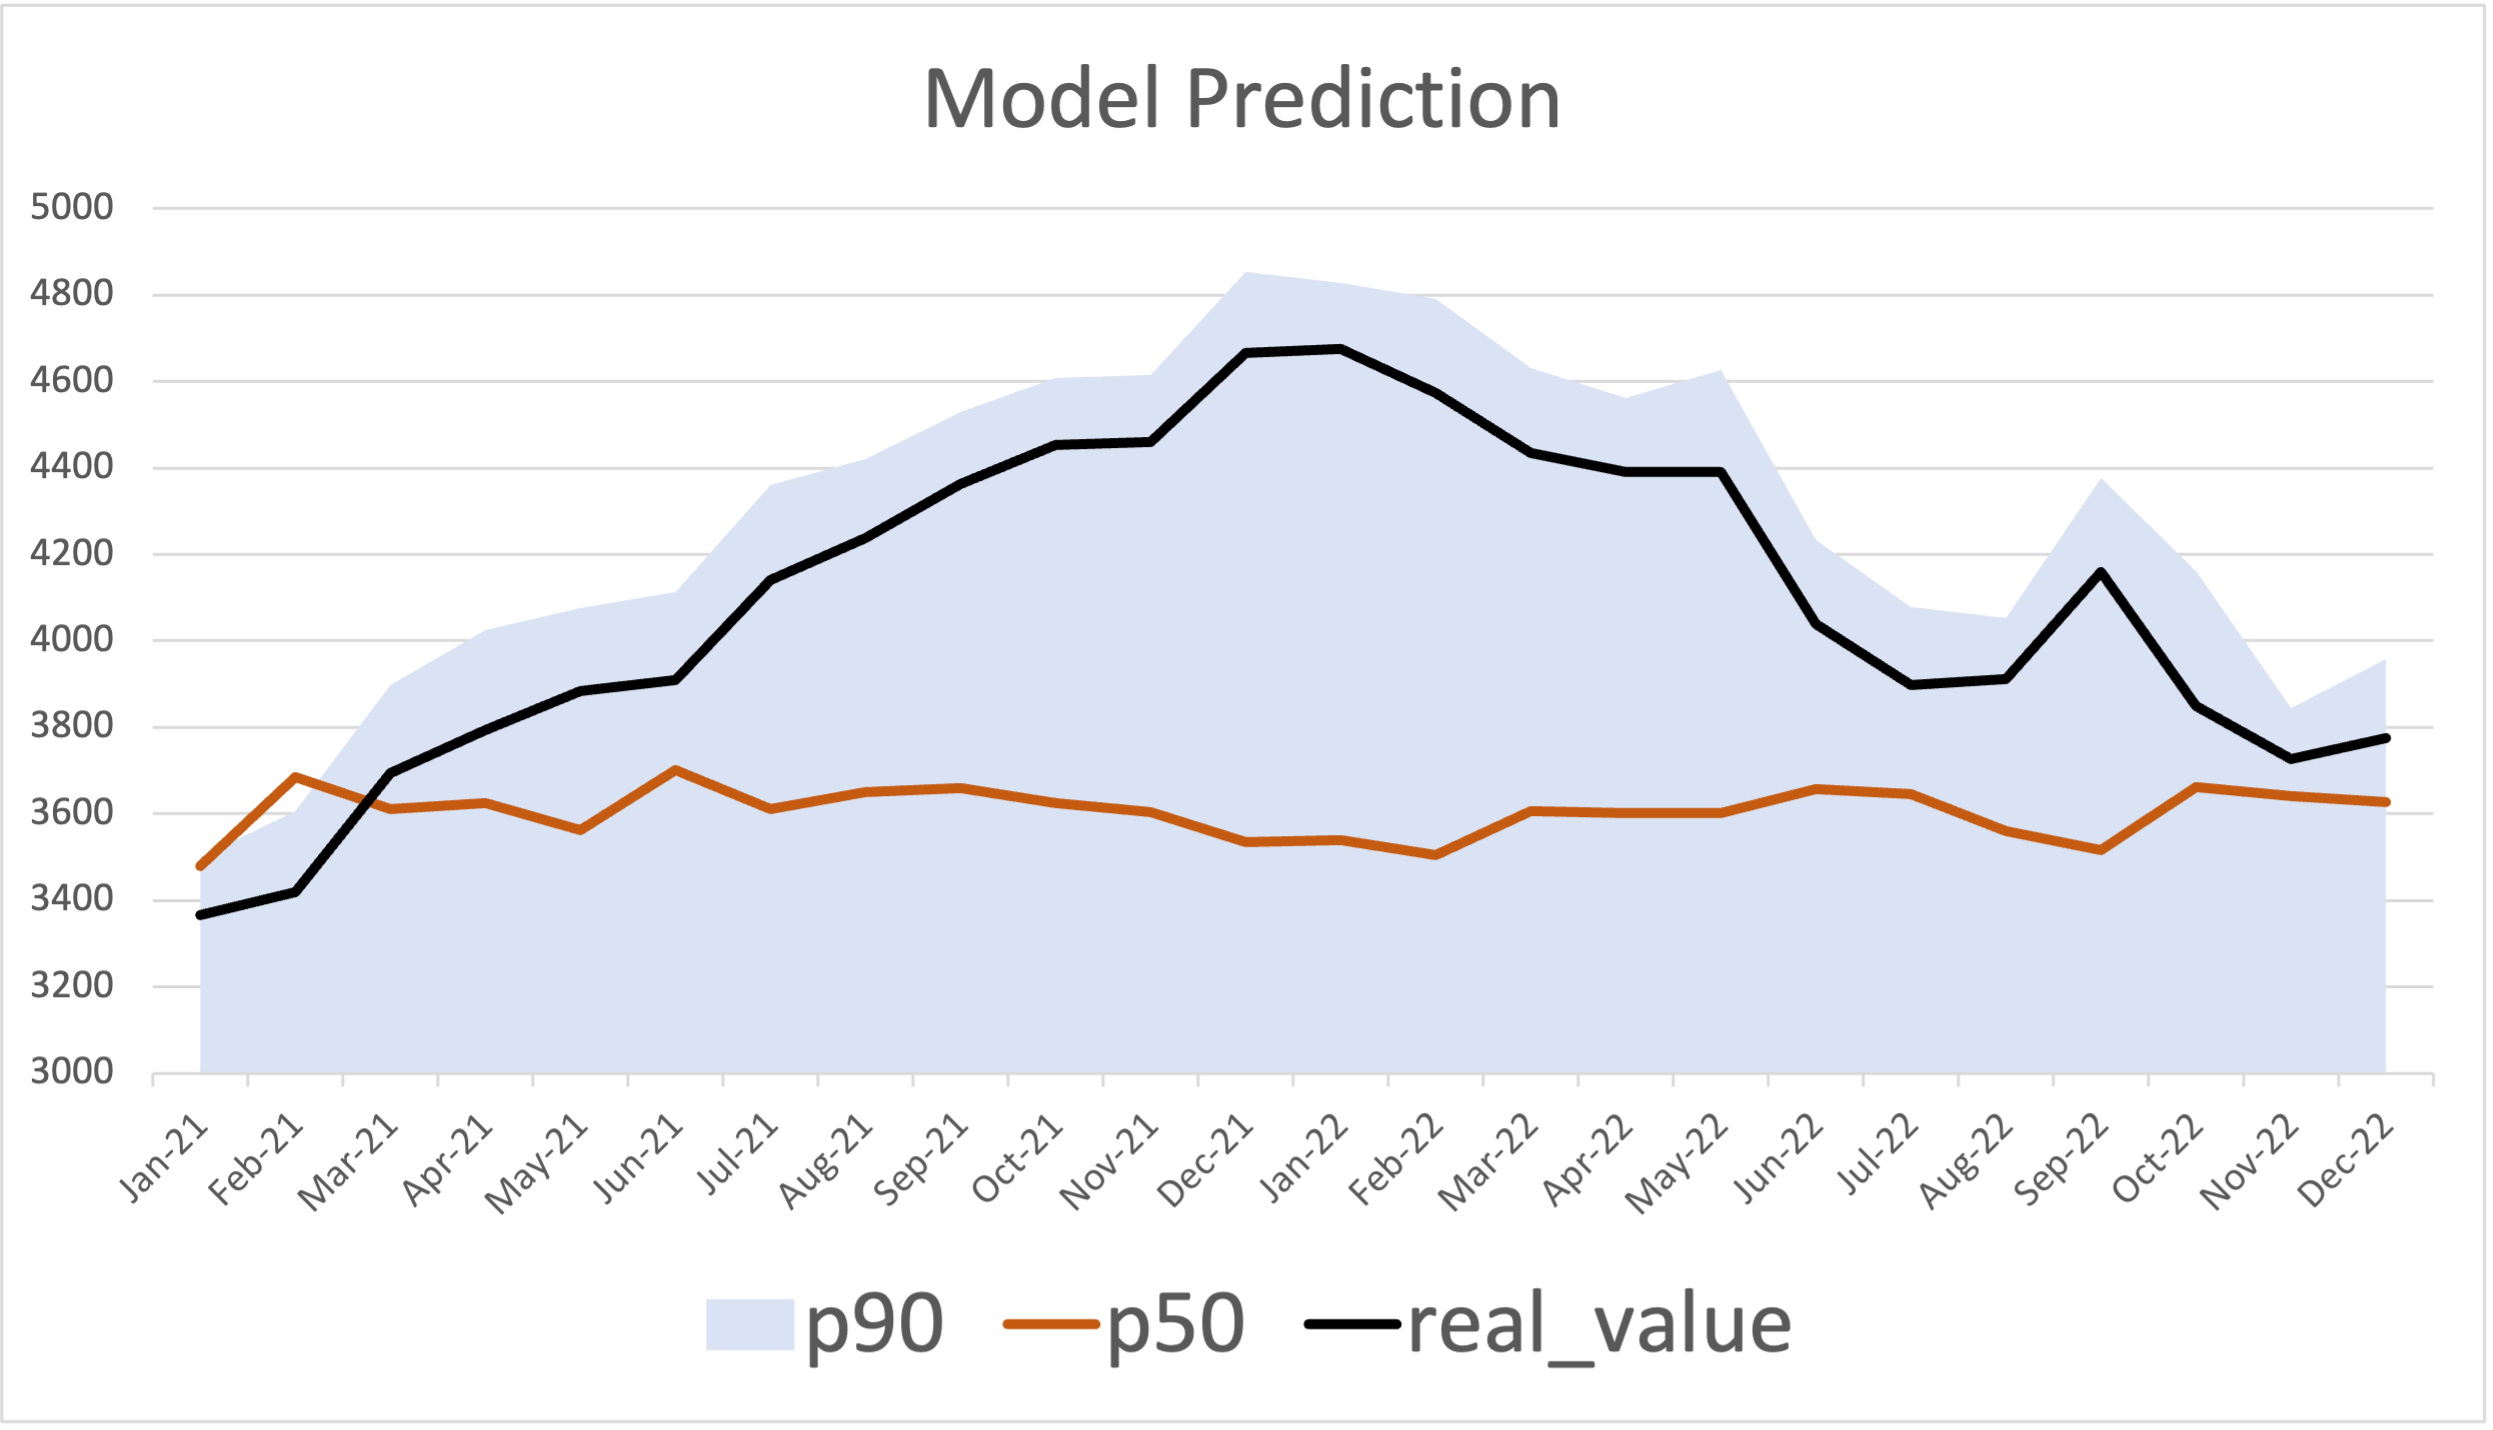

In [1]:
from IPython.display import Image
Image("/Users/srtpan/Downloads/prediction_deepar.png")

## References 

1. DeepAR resources

<li> DeepAR: Probabilistic forecasting with autoregressive recurrent networks , Salinas et al., 2020 </li>
<li> AWS Document on DeepAR: https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html </li> 


2. The code blocks in this notebook have borrowed some ideas for implementation from the following github repositories 

<li> https://github.com/jingw2/demand_forecast (Quoted by Haoming) </li> 
<li>  https://github.com/JellalYu/DeepAR </li> 
<li> https://github.com/brunoklein99/deepar </li>